# Homework 3

We first import the needed libraries and set the elements we need for the rest of the Homework.

In [1]:
# Used to look for the saved data
IMAGE_FOLDER = 'Data/Images/'
DATA_EUROPE = 'Data/une_rt_a.xls'
DATA_SWITZERLAND = 'Data/chomage.xlsx'
#DATA_SWITZERLAND_BY_AGE = 'Data/chomage_age.xlsx'
#DATA_SWITZERLAND_BY_NATIONALITY = 'Data/chomage_nationalite.xlsx'
DATA_SWITZERLAND_BY_NATIONALITY = 'Data/chomage_etrangers.xlsx'
DATA_SWITZERLAND_BY_AGE = 'Data/chomage_age_nat_2.xlsx'

In [2]:
swiss_geo_path = r'topojson/ch-cantons.topojson.json'
europe_geo_path = r'topojson/europe.topojson.json'

In [3]:
# Importing libraries
import os #might not be useful
import json #might not be useful
import folium
import pandas as pd
import pickle as pkl
import seaborn as sns #might not be useful
from IPython.display import Image #allows showing images
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Verifying we have the right version
folium.__version__ == '0.5.0'

## Unemployment in Europe

The very first thing we have to think about is what data we want to use. Eurostat has a lot of types of information, even more so, has information per country, but also per province/state of some countries (known as NUTS 2 regions). Thus, we have to determine what kind of information - and how much - we want to show.

Thus, we decide to take the **yearly** average for the unemployment rates and not the monthly ones, thus getting data from 2016 and not from 2017. For the monthly rates, we could have information for the beginning of this year, but we choose against it. This also permits to not have any fluctuation due to seasonal workers that would not be seen as unemployed for a time.

Secondly, seeing as the idea is to compare the unemployment rate of Europe to that of Switzerland, it would be more appropriate to take the data by country rather than that per NUTS 2 region, even more so seeing as Switzerland is cut in several in that dataset. So, to be able to compare it to Switzerland as a whole, we should have Switzerland as only one entity.

Therefore, we also need data that includes Switzerland, as it is not always the case for all files about unemployment in Europe. Thus, we had to dig a bit deeper and find data on unemployment according to age, sex and nationality (which contains rates for Switzerland, compared to data in the main indicators), which restricts it to people of age 15 to 74. This is actually what we want as those are the "adults" that could be potentially working already, and people that are younger or older should not count in our rates, as they aren't aprt of the working force.

Note that we also choose to delete all the columns we do not need (years other than 2016) and the data for the UE as a whole, which were the 4 first rows, before downloading the data.

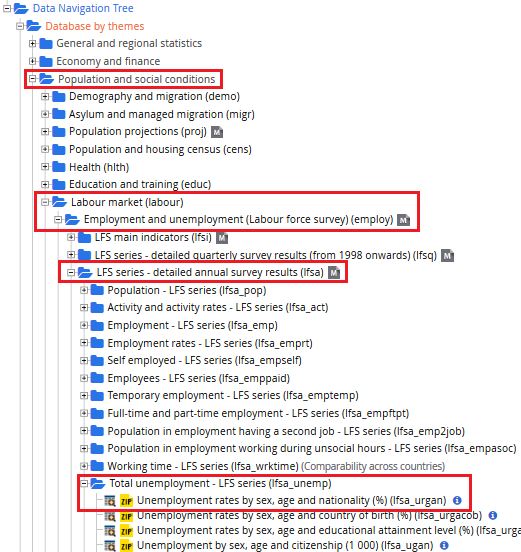

In [5]:
Image(IMAGE_FOLDER + 'euro01.png')

We also had the option to download the data in several different types of files, like HTML, CSV, TSV or XLS. We choose to download the data in a XLS format.

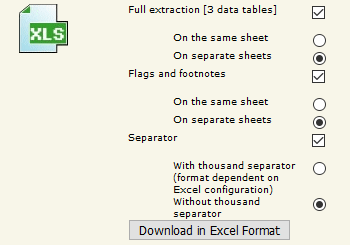

In [6]:
Image(IMAGE_FOLDER + 'euro02.png')

In [7]:
europe_unemployed = pd.read_excel(DATA_EUROPE, header=10)

In [8]:
europe_unemployed.head()

,GEO/TIME,2016
0,Belgium,7.8
1,Bulgaria,7.6
2,Czech Republic,4.0
3,Denmark,6.2
4,Germany (until 1990 former territory of the FRG),4.1


As we can see, we thus have the name in the country and the rate for 2016. The default coplumn names are a bit confusing, so we will quickly change this.

In [ ]:
europe_unemployed.columns = ['Country', 'Rate']

We also need to change the names of two countries, as we need to have "Germany" and "The former Yugoslav Republic of Macedonia" instead of "Germany (until 1990 former territory of the FRG)" and "Former Yugoslav Republic of Macedonia, the".

In [10]:
europe_unemployed = europe_unemployed.replace({"Germany (until 1990 former territory of the FRG)": "Germany",
                     "Former Yugoslav Republic of Macedonia, the": "The former Yugoslav Republic of Macedonia"})

In [11]:
europe_unemployed.head()

,Country,Rate
0,Belgium,7.8
1,Bulgaria,7.6
2,Czech Republic,4.0
3,Denmark,6.2
4,Germany,4.1


Now that this is done, we want to have a map of Europe with the given tiles already ready. As we all know, Switzerland is in the middle of Europe, so we're going to give the coordinates for the middle of Switzerland to have the map centered on.

In [37]:
central_swiss_coord = [46.484, 8.1336] 
m_europe = folium.Map(location=central_swiss_coord, zoom_start=4, tiles='cartodbpositron')

In [38]:
m_europe.choropleth(open(europe_geo_path),
             data=europe_unemployed,
             columns=('Country', 'Rate'),
             legend_name='Unemployment rate (%)',
             fill_color='RdYlGn',
             fill_opacity= 0.8,
             key_on = 'feature.properties.NAME',
             topojson='objects.europe')
m_europe

As we can see, for the countries we have no data on, the color that was chosen as default is a a vivid red. It is thus easy to see that the countries we have no information about are those not in the UE or in Schengen.

Here we can see that the difference in unemployment rates between Switzerland and a lot of it's neighboring countries (Germany, Austria, Poland, and so on) is basically the same, but it fares a lot better than two of it's direct neighbors: France and Italy. 

Thus, in terms of unemployment, Switzerland is one of the copuntries with the lowest rate, but not the only one to fare so well.

It is also important to note that the colors are a little bit misleading because of the way that choropleth maps reduce the threshold. Thus, we have any country with rating between 3 and 6 that has the same color as Switzerland. Seeing as the rate in Switzerland is 5%, this means that any country with less would have the same color, yet still fare better than Switzerland (which is a case for Germany or Iceland).

## Unemployment in Switzerland

In this exercise, we need several elements from the online data provided on the [amstat website](https://www.amstat.ch/v2/index.jsp). Each information we retrieve should be provided for every Swiss canton. To explain our methodology, we will include a print screen of each step we performed. As these steps are self-explanatory, we will not include any furter explanation on our methodology (however, the use of the retrieved data will be tackled in each question).

In [ ]:
Image(IMAGE_FOLDER + 'amstat01.png')

In [ ]:
Image(IMAGE_FOLDER + 'amstat02.png')

In [ ]:
Image(IMAGE_FOLDER + 'amstat03.png', retina = True)

In [ ]:
Image(IMAGE_FOLDER + 'amstat04.png', retina = True)

Once we retrieve our data using an XLS file (easier to work with), we still need to perform sanitizing steps before being able to draw our map:
- Deleting useless columns (and rows)
- Getting rid of the Multiindex
- Mapping each canton to its code (vital to draw our map)

In [ ]:
swiss_unemployment= pd.read_excel(DATA_SWITZERLAND, header=[0,1])
del swiss_unemployment['Mois'] #Only NaN values
del swiss_unemployment['Total'] #Same as 'Septembre 2017' as we only choose one month
swiss_unemployment.dropna(inplace=True) #We only need the values of each canton, not nationally

In [ ]:
swiss_unemployment.columns = [c[-1] for c in swiss_unemployment.columns]
swiss_unemployment.reset_index(inplace=True)
swiss_unemployment.rename(columns={'index': 'Région linguistique', 'Unnamed: 0_level_1':'Canton'}, inplace=True)
swiss_unemployment.head()

In [ ]:
dico = pkl.load(open('Data/map_cantons.pkl', 'rb'))
swiss_unemployment.insert(1, 'Code', swiss_unemployment['Canton'].map(dico))
swiss_unemployment

In [ ]:
### Unemployement rate of each Swiss canton

In the first question of Exercise 2, we simply plot the unemployment rate provided by the website (namely using the number of people looking for a job who either currently have a job or not).

In [ ]:
swiss_unemployment_map = folium.Map(location=[46.85, 8.23], zoom_start=8, tiles='cartodbpositron')
swiss_unemployment_map.choropleth(open(swiss_geo_path), data=swiss_unemployment,
             columns=['Code', 'Taux de chômage'],
             key_on='feature.id',
             topojson = 'objects.cantons',
             fill_color='OrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment (%)')
swiss_unemployment_map

Analysis (en cours)

### Unemployement rate (of people without a job) of each Swiss canton

In this question we will focus on the "real" unemployment rate of people who currently do not have a job (which seems more sound than looking at people who do have a job but are simply looking for a new one). However, to be able to do that, we first need to determine the actual unemployment rate.

When trying to compute the active population of each canton, we found results differing from those of the [Federal Statistical Office](https://www.bfs.admin.ch/bfs/en/home.html). Even though these numbers are not up to date, we decided to try another method to calculate the rate : we first calculate the rate of people without a job and multiply it by the total rate of unemployed people.

In [ ]:
real_swiss_unemployment = swiss_unemployment
del real_swiss_unemployment['Demandeurs d\'emploi non chômeurs']
real_swiss_unemployment['Taux de chômage'] = (real_swiss_unemployment['Chômeurs inscrits'] / real_swiss_unemployment['Demandeurs d\'emploi'])*real_swiss_unemployment['Taux de chômage']
#real_swiss_unemployment['Taux de chômage'] = pd.to_numeric(real_swiss_unemployment['Taux de chômage']).map('{:,.2f}'.format)
real_swiss_unemployment.head()

In [ ]:
real_swiss_unemployment_map = folium.Map(location=[46.85, 8.23], zoom_start=8, tiles='cartodbpositron')
real_swiss_unemployment_map.choropleth(open(swiss_geo_path), data=real_swiss_unemployment,
             columns=['Code', 'Taux de chômage'],
             key_on='feature.id',
             topojson = 'objects.cantons',
             fill_color='OrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment (%)')
real_swiss_unemployment_map

Analysis (en cours)

### Differences in unemployment between foreigners and natives

Here we have two different questions again: one about the difference in employment regarding nationality, and the second regarding age. We proceed to the amstat website and select the following categories:

In [ ]:
Image(IMAGE_FOLDER + 'categories_q3.png', width='450px')

After the selection we are asked to specifiy the age range: we choose to use 3 categories

In [ ]:
Image(IMAGE_FOLDER + 'age_selection.png')

After having selected out criteria we can further pivot and unpivot the rows using the websites tools:

We start out with the following allignment. By clicking on the pivot button we can change this lignup to have 2 columns, one for foreigners and one for swiss nationals

In [ ]:
Image(IMAGE_FOLDER + 'foreigners_1.png', width='450px')

In [ ]:
Image(IMAGE_FOLDER + 'foreigners_2.png', width='450px')

We can use this set up without having to preform transformations on the columns.

We import the data set downloaded previously.
We only need to flatten some of the structure.

In [ ]:
swiss_foreign_unemployed = pd.read_excel(DATA_SWITZERLAND_BY_NATIONALITY, header=[0,2]) 

In [ ]:
del swiss_foreign_unemployed['Nationalité'] ##remove Measures column
swiss_foreign_unemployed.columns = swiss_foreign_unemployed.columns.droplevel(1) ##remove redunant multiindex

In [ ]:
swiss_foreign_unemployed.head()

To later easely map the values in the dataframe to the shapes as provided in the topojson we preform a mapping, as before:

In [ ]:
swiss_foreign_unemployed['Code'] = swiss_foreign_unemployed.index.to_series().map(dico)

We calculate different measures to look at the difference between unemploment between two groups.
The difference (scaled by the general unemploment rate) and the rate both show different trends.

In [ ]:
total = swiss_foreign_unemployed['Etrangers'] + swiss_foreign_unemployed['Suisses'] #this should be oths general data
swiss_foreign_unemployed['Difference'] = (swiss_foreign_unemployed['Etrangers'] - swiss_foreign_unemployed['Suisses']) / total
swiss_foreign_unemployed['Ratio'] = swiss_foreign_unemployed['Etrangers'] / swiss_foreign_unemployed['Suisses']

In [ ]:
swiss_foreign_unemployed.head()

We first look at the ratio. We can observe that the difference between the unemploment rate is smaller in urbanized areas such as Geneva or Zurich and bigger in rural areas, such as Uri and Glarus. 
Looking at the absolute rates, we see that areas with high disparoties have very low rates of unemployment in general. 

In [ ]:
swiss_foreign_map = folium.Map(location=[46.85, 8.23], zoom_start=8, tiles='cartodbpositron')
swiss_foreign_map.choropleth(open(swiss_geo_path),
             data=swiss_foreign_unemployed,
             columns=('Code', 'Ratio'),
             legend_name='Ratio in unemployment (%)',
             fill_opacity=0.7, line_opacity=0.2,
             fill_color='OrRd',
             key_on = 'feature.id',
             topojson='objects.cantons')
swiss_foreign_map

In [ ]:
swiss_foreign_map = folium.Map(location=[46.85, 8.23], zoom_start=8, tiles='cartodbpositron')
swiss_foreign_map.choropleth(open(swiss_geo_path),
             data=swiss_foreign_unemployed,
             columns=('Code', 'Difference'),
             legend_name='Ratio in unemployment (%)',
             fill_opacity=0.7, line_opacity=0.2,
             fill_color='OrRd',
             key_on = 'feature.id',
             topojson='objects.cantons')
swiss_foreign_map

### Differences in unemployment between swiss and foreign workers by age groups

Getting this dataset was more involved, as one had to select the correct links to be able to get the data by age and nationality at the same time.

Here we show the path we used:
We had to click on monthly reports, and then get the unemploment rate by different categories.
By using this path we get complete controll over what data we want.

In [ ]:
Image(IMAGE_FOLDER + 'find_folder.png', width='300px')

In [ ]:
Image(IMAGE_FOLDER + 'find_folder_2.png', width='300px')

We now read the data into a dataframe. Note that for some cantones, some values are not present, and makrked by '...'. We transform these values into NaN as to more easly handle them.

In [ ]:
swiss_unemployed_age = pd.read_excel(DATA_SWITZERLAND_BY_AGE, header=[0,1], na_values='...') 

swiss_unemployed_age.columns = swiss_unemployed_age.columns.droplevel(1)
del swiss_unemployed_age["Mois"] #remove empty line

In [ ]:
swiss_unemployed_age['Code'] = swiss_unemployed_age.index.to_series().map(dico)
swiss_unemployed_age.reset_index(inplace=True)

In [ ]:
swiss_unemployed_age.head() #what looks like 2 columns is 1 :S

In [ ]:
#renaming columns for convenience
swiss_unemployed_age.columns = ['index', 'Nationalité', 'Category Name',
       "Age class: 15-24, 25-49, 50 ans and up", 'Unemployment rate', 'Code']

In [ ]:
del swiss_unemployed_age['Category Name']

In the exercise we are asked to draw a bar plot. We found that adding even with the bar plot it is quite hard to get a good overview of the data. In our first attempt we plot two barplots.
We found that using the Canton as the x axis gives the most redable charts, as otherwise the Cantons are color coded.

In [ ]:
#yet to find good plot
sns.factorplot(#col="Nationalité", 
                   y='Unemployment rate', 
                   hue='Age class: 15-24, 25-49, 50 ans and up',
                   x='Code',
                   data=swiss_unemployed_age[swiss_unemployed_age['Nationalité'] == 'Etrangers'],
                   kind="bar",     
                   palette="Blues", size=5, aspect=3)
sns.factorplot(#col="Nationalité", 
                   y='Unemployment rate', 
                   hue='Age class: 15-24, 25-49, 50 ans and up',
                   x='Code',
                   data=swiss_unemployed_age[swiss_unemployed_age['Nationalité'] == 'Suisses'],
                   kind="bar",     
                   palette="Reds", size=5, aspect=3)

In [ ]:
plt.figure(figsize=(15,7.5))
g = sns.barplot(y='Unemployment rate', 
                   hue='Age class: 15-24, 25-49, 50 ans and up',
                   x='Code',
                   data=swiss_unemployed_age[swiss_unemployed_age['Nationalité'] == 'Etrangers'], 
                   palette="Blues")
sns.barplot(y='Unemployment rate', 
                   hue='Age class: 15-24, 25-49, 50 ans and up',
                   x='Code',
                   data=swiss_unemployed_age[swiss_unemployed_age['Nationalité'] == 'Suisses'], 
                   palette='Reds'
           )

we observe that a lot of elderly foreigners are more unemployed. 
For both groups young people have the highest unemployment rate.
In some cantons younger people suffer much higher rates of unemployment.
We should check if this coincides with foreigners and swiss nationals

Finaly we decide to also show the distribution over all cantons using boxplots.

In [ ]:
sns.boxplot(x='Nationalité', 
            y='Unemployment rate', 
            hue='Age class: 15-24, 25-49, 50 ans and up', data=swiss_unemployed_age)

In [ ]:
sns.boxplot(hue='Nationalité', 
            y='Unemployment rate', 
            x='Age class: 15-24, 25-49, 50 ans and up', data=swiss_unemployed_age)

We see that the discrepancy between the foreigners and swiss nationals is largest for the age group 50 and above.

### The Röstigraben

The röstigraben, that is the cultural gap between german and french speaking switzerland is visible in our analysis.
We note that the french are more unemployed, but have a smaller gap between foreigners and swiss nationals.